In [11]:
import torch
from torchvision import datasets, transforms
from siren import Sine

In [107]:
batch_size = 1
transform=transforms.ToTensor()
# dataset_train = datasets.MNIST('data', train=True, download=True,transform=transform)
dataset_train = datasets.Caltech101('data', download=True, transform=transform)
dataloader_train = torch.utils.data.DataLoader(dataset_train,batch_size=batch_size,shuffle=True,num_workers=4)

Downloading...
From (original): https://drive.google.com/uc?id=137RyRjvTBkBiIfeYBNZBtViDHQ6_Ewsp
From (redirected): https://drive.usercontent.google.com/download?id=137RyRjvTBkBiIfeYBNZBtViDHQ6_Ewsp&confirm=t&uuid=1da51388-05ff-4f50-80db-9097f34657ae
To: c:\Users\db2admin\Documents\eecs6322_project\data\caltech101\101_ObjectCategories.tar.gz
100%|██████████| 132M/132M [00:13<00:00, 9.45MB/s] 


Extracting data\caltech101\101_ObjectCategories.tar.gz to data\caltech101


Downloading...
From: https://drive.google.com/uc?id=175kQy3UsZ0wUEHZjqkUDdNVssr7bgh_m
To: c:\Users\db2admin\Documents\eecs6322_project\data\caltech101\Annotations.tar
100%|██████████| 14.0M/14.0M [00:01<00:00, 9.57MB/s]


Extracting data\caltech101\Annotations.tar to data\caltech101


In [203]:
im, label = next(iter(dataloader_train))

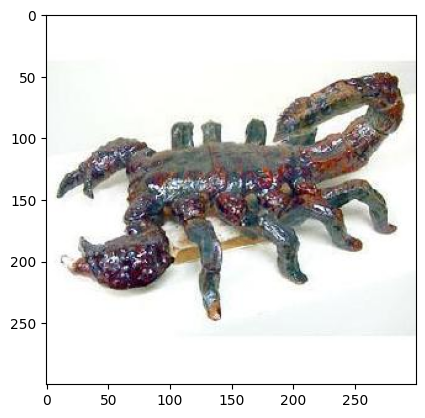

In [204]:
# plot image using maplotlib
import matplotlib.pyplot as plt
plt.imshow(im[0].permute(1, 2, 0))

In [205]:
im.shape

torch.Size([1, 3, 300, 300])

In [146]:
class coordx_net(torch.nn.Module):
    def __init__(self, channels, hidden_size=256):
        super(coordx_net, self).__init__()
        self.channels=channels
        self.x_first = torch.nn.Linear(1,hidden_size)
        self.y_first = torch.nn.Linear(1,hidden_size)
        self.premerge_parallels = torch.nn.Sequential(
            Sine(),
            torch.nn.Linear(hidden_size,hidden_size),
            Sine(),
            torch.nn.Linear(hidden_size,hidden_size),
            Sine()
        )
        
        self.postmerge = torch.nn.Sequential(
            torch.nn.Linear(hidden_size,hidden_size),
            Sine(),
            torch.nn.Linear(hidden_size,self.channels),
            torch.nn.Sigmoid()
        )
    
    def merge(self,x,y):
        return torch.einsum("ik,jk->ijk",x,y)

    def forward(self, x, y):
        x1 = self.x_first(x)
        y1 = self.y_first(y)
        x2 = self.premerge_parallels(x1)
        y2 = self.premerge_parallels(y1)
        merged = self.merge(x2,y2)
        res = self.postmerge(merged)
        # reshape to (channels, x, y)
        res = res.permute(2,0,1)
        return res

In [206]:
x_coords = 300
y_coords = 300 

In [207]:
x = torch.linspace(1, x_coords, x_coords).reshape(x_coords,1)
y = torch.linspace(1, y_coords, y_coords).reshape(y_coords,1)

In [208]:
net = coordx_net(channels=3)
loss_fn = torch.nn.MSELoss()
optimizer = torch.optim.Adam(net.parameters(), lr=0.001)

In [212]:
for epoch in range(200):
    optimizer.zero_grad()
    out = net(x,y)
    loss = loss_fn(out, im[0])
    loss.backward()
    optimizer.step()

    if epoch % 10 == 0:
        print(f'Iteration: {epoch} | Loss: {loss.item()}')

Iteration: 0 | Loss: 0.0025342151056975126
Iteration: 10 | Loss: 0.002470731269568205
Iteration: 20 | Loss: 0.0023733924608677626
Iteration: 30 | Loss: 0.002318047219887376
Iteration: 40 | Loss: 0.002280944027006626
Iteration: 50 | Loss: 0.0024052723310887814
Iteration: 60 | Loss: 0.002245120005682111
Iteration: 70 | Loss: 0.0022098158951848745
Iteration: 80 | Loss: 0.002159715397283435
Iteration: 90 | Loss: 0.002116208663210273
Iteration: 100 | Loss: 0.002100710989907384
Iteration: 110 | Loss: 0.002113542053848505
Iteration: 120 | Loss: 0.002066391985863447
Iteration: 130 | Loss: 0.0020108066964894533
Iteration: 140 | Loss: 0.0019692096393555403
Iteration: 150 | Loss: 0.0022464890498667955
Iteration: 160 | Loss: 0.0019840567838400602
Iteration: 170 | Loss: 0.001913383835926652
Iteration: 180 | Loss: 0.001865477068349719
Iteration: 190 | Loss: 0.0018365350551903248


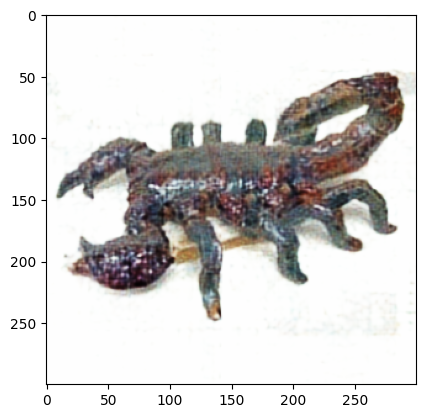

In [213]:
merged = net(x,y)
plt.imshow(merged.detach().permute(1, 2, 0).numpy())
plt.show()
# 500 epochs

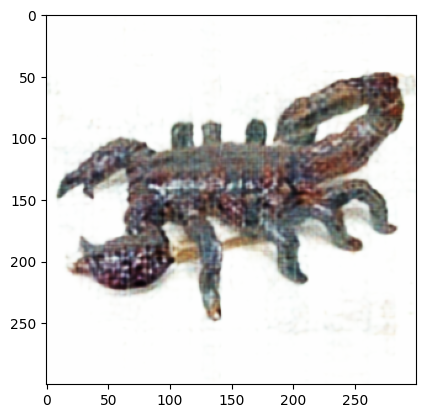

In [211]:
# plot the output of the network
plt.imshow(merged.detach().permute(1, 2, 0).numpy())
# plt.imshow(merged[0,:,:].detach().numpy(), cmap='gray')
plt.show()
# 300 epochs